$$\large{\color{blue}{Binary \space Classification : }}$$

$Realized \space By : Narjes \space Haouala-Mootez \space Dakhlaoui-Saifeddine\space Barkia-Taher\space Romdhane $


$We \space Worked\space On\space Google\space Collab\space For\space this\space Notebook\space (Compatiblity \space for\space the\space GPU)$

# I. Importing modules

In [1]:
# Please install those modules
!pip install  mahotas
!pip install opencv-python

     |████████████████████████████████| 5.7MB 3.7MB/s 


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

plt.close('all')
# For data pre-processing.

from skimage.io import imread
from IPython.display import display, Math, Latex
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from skimage.transform import resize
from skimage.transform import rescale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
# For feature extraction 

from sklearn.cluster import KMeans
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import hog
from skimage.filters import sobel

# Classical Machine learning

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import matthews_corrcoef
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#Libraries for deep learning 

import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import  EarlyStopping
import mahotas

#libraries for metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef


In [4]:
# please change the directory if you are going to run the code on your machine
Ants_directory ='G_23_ant.npy'
grapes_directory ='G_23_grapes.npy'

In [5]:
ants = np.load(Ants_directory)
grapes = np.load(grapes_directory)

# II. Exporatory Analysis  / ***Visualisation***

In [6]:
print("Shape of Ants Dataset",ants.shape)
print("Shape of Grapes Dataset",grapes.shape)

Shape of Ants Dataset (1000, 784)
Shape of Grapes Dataset (1000, 784)


$\large{\underline{\color{blue}{interpretation: }}}$

**According to the shape, we have that every row corresponds to an observation. Every observation is an image of shape 28 x 28. Let's try to visualize some of the images.**

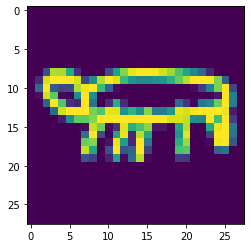

In [ ]:
plt.imshow(ants[0].reshape(28,28))

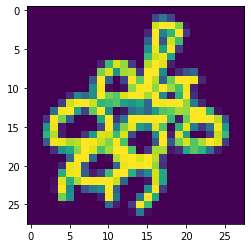

In [ ]:
plt.imshow(grapes[9].reshape(28,28))

**Let's Visualize some of samples of bot classes**

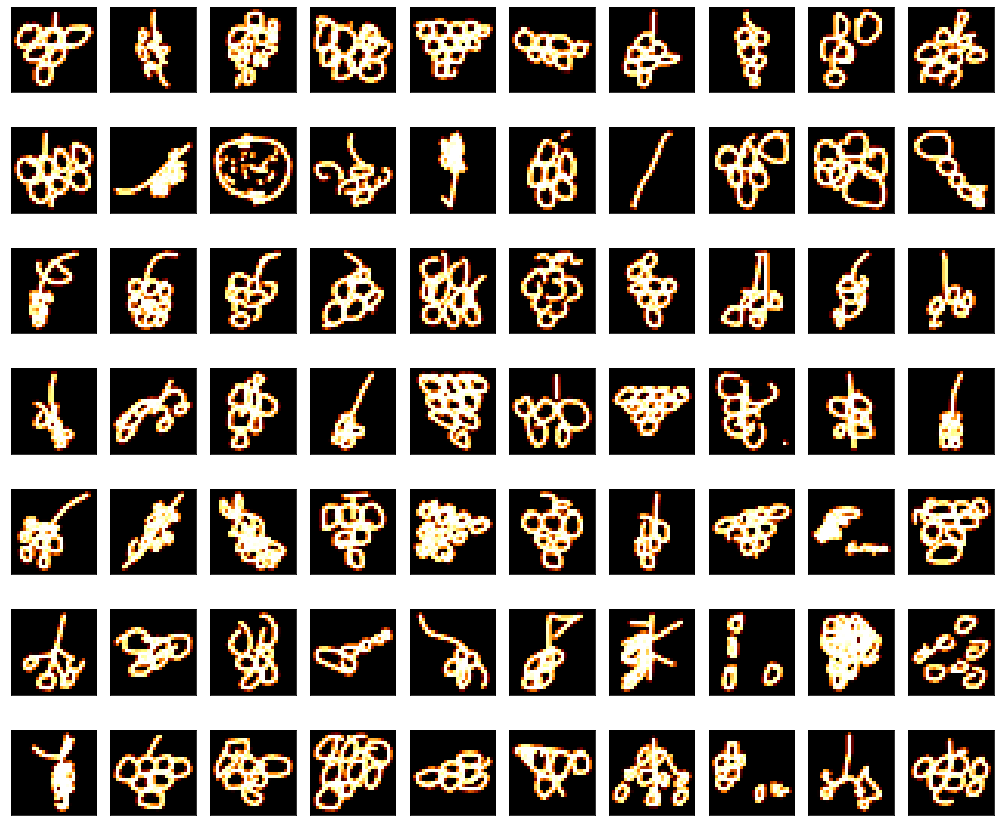

In [ ]:
plt.figure(figsize=(14,12))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = grapes[digit_num].reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

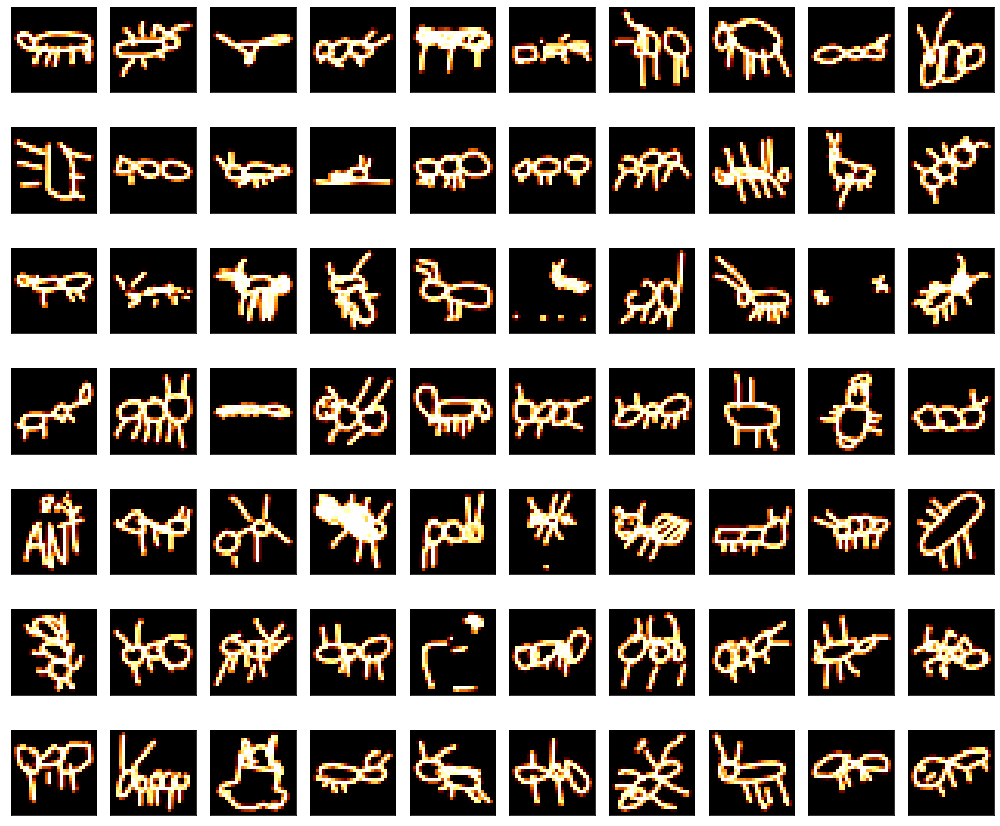

In [ ]:
plt.figure(figsize=(14,12))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = ants[digit_num].reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

$\large{\underline{\color{blue}{interpretation: }}}$

In order to train our machine learning model , we need to create labels for the images. We will assign the value **1** for the **ants** and the value **0** for the **grapes**. 

**After that, we are going to concatenate the two data sets so that we will have only 1 data set to approach the classification problem.**

In [7]:
ones = np.ones((ants.shape[0],1)) #
zeroes = np.zeros((grapes.shape[0],1))

Ants_labled = np.hstack((ants,ones))
Grapes_labled = np.hstack((grapes,zeroes))

All_data = np.vstack((Ants_labled,Grapes_labled))

$\large{\underline{\color{blue}{interpretation: }}}$

**The problem of having a block of data one on the top of the other , is that we will allow the model to learn some pattern that will lead to overfitting. For that reason, we are going to shuffle the data set to avoid this kind of problem.**

In [8]:
indices=np.arange(All_data.shape[0]) # Integers from 0 to number of data
np.random.shuffle(indices)
All_data=All_data[indices,:]

In [9]:
y = All_data[:,-1] # retrieving the labels 
All_data = All_data [:,:-1] # retrieving only the data

**Let's visualize some of the samples of the dataset that we have obtained.**

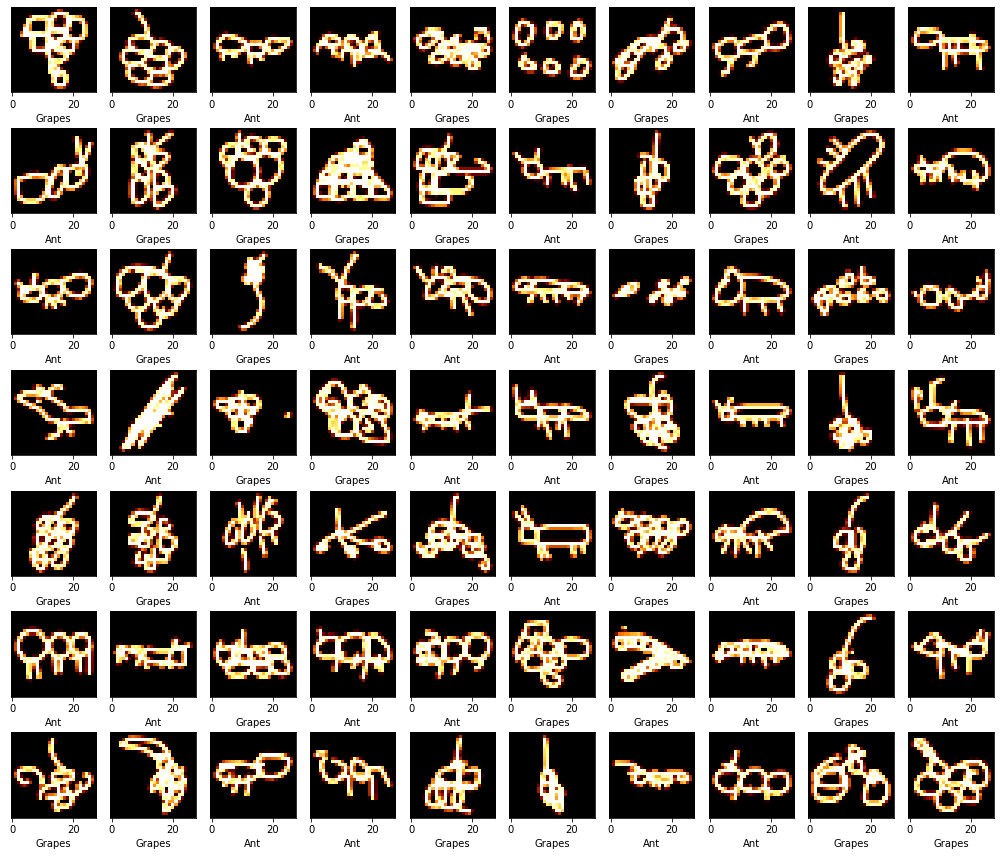

In [ ]:
dic = {}
dic[1] = 'Ant'
dic[0] = 'Grapes'
plt.figure(figsize=(14,12))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = All_data[digit_num].reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xlabel(dic[y[digit_num]])
    plt.yticks([])

plt.tight_layout()

$\large{\underline{\color{blue}{interpretation: }}}$

**The data set is now ready to be trained, now we are going to divide it into train/ validation / test sets to train the model.** 

**Note :**

**For every algorithm that we are going to train, we will are going to use a $\large{gridsearch}$ approach to search for the best hyperparamter for this algorithm. Since the gridsearch uses a crossvalidation technique, we will concatenate the train and validation sets together and then test the perfomance of our model on the test data set.**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(All_data, y, test_size=0.1, random_state=42)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1440, 784)
(360, 784)
(200, 784)


# Data visualization using PCA / LDA

$\large{\underline{\color{blue}{interpretation: }}}$

**For this part, we are going to use 2 techniques of dimension reduction and try to generate some conclusion about our data.** 

**We will first start with the $\large{PCA}$ (like we have seen it in course ) technique and then we will explore the $\large {LDA}$  technique.**

**First of all, let's compare between the two methods : Linear Discriminant Analysis $\large{(LDA)}$ and Principal Component Analysis $\large{(PCA)}$ are both linear transformation approaches. PCA finds the directions (principal components) that optimize the data's variance, while LDA seeks to find the directions that maximize the distinction (or discrimination) between different groups, which may be useful in pattern classification problems (PCA "ignores" class labels).** 

**To put it another way, PCA projections the entire dataset onto a separate feature (sub)space, while LDA attempts to find a fitting feature (sub)space to differentiate between patterns belonging to different groups.**

## PCA

In [13]:
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.offline as py

In [14]:
n_components = 30
pca = PCA(n_components=n_components).fit(X_train)

eigenvalues = pca.components_.reshape(n_components, 28, 28)

# Extracting the PCA components ( eignevalues )
eigenvalues = pca.components_

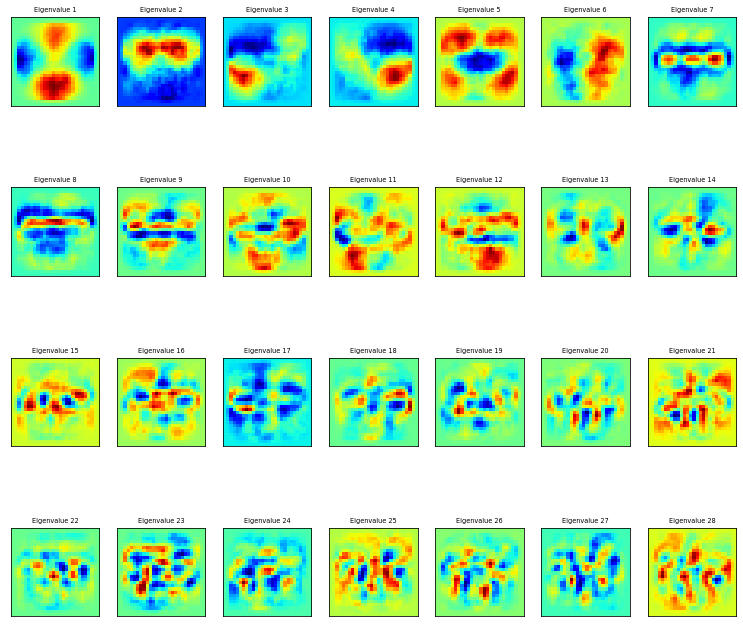

In [20]:
n_row = 4
n_col = 7

# Plot the first 8 eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(28,28), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

$\large{\underline{\color{blue}{interpretation: }}}$

**The subplots above portray the top 30 principal component axes that the PCA method has decided to generate for our ants-grapes dataset. Of interest is when one compares the first component "Eigenvalue 1" to the 28th component "Eigenvalue 28", it is obvious that more complicated direction sare being generated in the search to maximise variance in the new feature subspace. Add to that, we can clearly see that the first 5 directions are the most important one since they have the form of circles, which we find in both the morphology of the ants and of the grapes.**

In [21]:
X= X_train
# Standardising the values
X_std = StandardScaler().fit_transform(X)

# Call the PCA method with components that explains 95% of the variablity of the data. 
pca = PCA(n_components=0.95)
pca.fit(X_std)
X_pca = pca.transform(X_std)

# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target = y_train

In [22]:
X_pca.shape

(1440, 291)

In [23]:
trace0 = go.Scatter(
    x = X_pca[:,0],
    y = X_pca[:,1],
#     name = Target,
#     hoveron = Target,
    mode = 'markers',
    text = Target,
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

$\large{\underline{\color{blue}{interpretation: }}}$

* **When we visualize only 2 principle componeents of the PCA , we can clearly see that we have some common pattern to seperate the data. It's obvious that we are going to need more than 2 components in order to well seperate the two classes since the data is $\large{overlapping}$ in this feature space.**


* **As observed from the scatter plot, you can just about make out a few discernible clusters evinced from the collective blotches of colors. These 2 clusters represent the 2 classes ( ants and grapes)  that each data point should contribute to.**

**Let's assume for a second that we don't have, any labels to train our model on and let's see how the model behave on this data.**

In [24]:
from sklearn.cluster import KMeans # KMeans clustering 
# Set a KMeans clustering with 2 components 
kmeans = KMeans(n_clusters=2)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_pca)

trace_Kmeans = go.Scatter(x=X_pca[:, 0], y= X_pca[:, 1], mode="markers",
                    showlegend=False,
                    marker=dict(
                            size=8,
                            color = X_clustered,
                            colorscale = 'Portland',
                            showscale=False, 
                            line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        )
                   ))

layout = go.Layout(
    title= 'KMeans Clustering',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)

data = [trace_Kmeans]
fig1 = dict(data=data, layout= layout)
# fig1.append_trace(contour_list)
py.iplot(fig1, filename="svm")

In [25]:
accuracy_score(y_train, X_clustered)

0.19722222222222222

$\large{\underline{\color{blue}{interpretation: }}}$

* **So, we can see that the results that the k-means predict are bad, but it looks that the data is linearly seperable, which is not the case.** 

**We will now take a look at the LDA technique.**

## LDA

In [ ]:
lda = LDA(n_components=5)
# Taking in as second argument the Target as labels
X_LDA_2D = lda.fit_transform(X_std, Target )

In [ ]:
X_LDA_2D.shape

(1440, 1)

In [ ]:
traceLDA = go.Scatter(
    x = X_LDA_2D[:,0],
    mode = 'markers',
    text = Target,
    showlegend = True,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [traceLDA]

layout = go.Layout(
    title= 'Linear Discriminant Analysis (LDA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Linear Discriminant',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Linear Discriminant',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

$\large{\underline{\color{blue}{interpretation: }}}$

* **As we can clearly see, the data is not linearly seperable ( at least when we considered only 2 componenets ), so we are going to need more complex algorithm than SVMs in order to well classify our data set.**

**First of all, we will test some algorithm directly on the images ( which contains either 0 or 1 values ) ,which we think is not that convenient. We will try some algorithms on the original data  and then for the next part, we will explore some feature extraction techniques on which we will do the analysis and interpretation.**


**Note:** For this part wil will not do many interpretation because of the redandency of the code that we will have with the next part of the report.

**Let's start :** 

# III.Predictive Models on the original data

In [32]:
## As we have said before, for the classical machine learning algorithms, we will concatenate the valdiation and train data sets
## Since we will perform cross validation

trainX = np.concatenate([X_train,X_valid],axis =0)
y_train_val = np.concatenate([y_train,y_valid],axis=0)

Since we are dealing with 0 / 255 values, data normalization will not affect that much the results. 

In [33]:
# SVM
grid={"C":[0.01,0.02,0.1,1,2,3,10,20,30], "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(trainX,y_train_val)

print("Best Validation Score: {}".format(logreg_cv.best_score_))
print("Best params: {}".format(logreg_cv.best_params_))
# print("Random Forest test score :",logreg_cv.score(X_valid,y_valid))
y_pred = logreg_cv.predict(X_test)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best Validation Score: 0.6994444444444444
Best params: {'C': 3, 'penalty': 'l2'}
test score , Accuracy 0.715
test score, f1_score 0.7076923076923077
test score, matthews_corrcoef 0.4325473482689406
test score, roc_auc_score 0.7157863145258103
test score, log_loss 9.843647224241167


In [34]:
#KNN
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(trainX, y_train_val)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
# print("KNN test score :",grid_KNN.score(X_valid,y_valid))
y_pred = grid_KNN.predict(X_test)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best training Score: 0.865
Best training params: {'n_neighbors': 8}
test score , Accuracy 0.905
test score, f1_score 0.9073170731707318
test score, matthews_corrcoef 0.8099264775370641
test score, roc_auc_score 0.9048619447779112
test score, log_loss 3.2812237373880246


In [36]:
# SVM
p_grid_lsvm = {'C': [1e-4,1e-3,1e-2,1,1e1,20,50,100,150,200,300]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
#grid_lsvm contain the best estimator
grid_lsvm.fit(trainX, y_train_val)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
print("SVM test score :",grid_lsvm.score(X_test,y_test))
y_pred = grid_lsvm.predict(X_test)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))


Best training Score: 0.7055555555555555
Best training params: {'C': 0.0001}
SVM test score : 0.7
test score , Accuracy 0.7
test score, f1_score 0.7000000000000001
test score, matthews_corrcoef 0.4005602240896359
test score, roc_auc_score 0.7002801120448179
test score, log_loss 10.361744862113433


In [38]:
# Non linear SVM
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(trainX, y_train_val)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
print("SVM test score :",grid_nlsvm.score(X_test,y_test))
y_pred = grid_nlsvm.predict(X_test)


print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best training Score: 0.5011111111111111
Best training params: {'C': 0.001, 'gamma': 0.0001}
SVM test score : 0.49
test score , Accuracy 0.49
test score, f1_score 0.0
test score, matthews_corrcoef 0.0
test score, roc_auc_score 0.5
test score, log_loss 17.614775961404447


$\large{\underline{\color{green}{Conclusion \:  for \: this \:part: }}}$

* As we can see, when we trained the algorithms directly on images, we didn't get that of the results since training on images pixels is not totally convinents espacially for classical machine learning algorihtms ( like SVMs , Random forest ect..). 

For that reason, we will try try 2 different approaches.
* First of all, we will use the dimension reduction technique ( PCA ) to extract the most convenient directions to train the model on.

* Second, we will extract some features from images that characterizes the most convenient points on the images, which will improve the model.

# IV. PCA on data.

In [ ]:
## As we have said before, for the classical machine learning algorithms, we will concatenate the valdiation and train data sets

trainX = np.concatenate([X_train,X_valid],axis =0)
y_train_val = np.concatenate([y_train,y_valid],axis=0)


In [ ]:
# Normalization
scaler = StandardScaler()

# We fit only on the training dataset
scaler.fit(trainX)
# We apply the learned parameters on the train set to the train and test sets

X_train_scale = scaler.transform(trainX)
X_test_scale = scaler.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(random_state=1,n_components=0.992) # taking the features that explain 99% of the variability of the data

# We will fit and transforme the train dataset 

X_train_pca  = pca.fit_transform(X_train_scale)
# We will apply the fitted pca on the test dataset.

X_test_pca = pca.transform(X_test_scale)
X_train_pca.shape

(1800, 492)

In [ ]:
grid={"C":[0.01,0.02,0.1,1,2,3,10,20,30], "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_pca,y_train_val)

print("Best training  Score: {}".format(logreg_cv.best_score_))
print("Best params : {}".format(logreg_cv.best_params_))
print("Logistic Regression test score, accuracy :",logreg_cv.score(X_test_pca,y_test))
y_pred = logreg_cv.predict(X_test_pca)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))


Best training  Score: 0.8444444444444444
Best params : {'C': 0.01, 'penalty': 'l2'}
Logistic Regression test score, accuracy : 0.84
test score , Accuracy 0.84
test score, f1_score 0.8431372549019608
test score, matthews_corrcoef 0.6813862934183602
test score, roc_auc_score 0.8411027568922306
test score, log_loss 5.526256197018672


In [ ]:
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train_pca, y_train_val)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
print("KNN test score :",grid_KNN.score(X_test_pca,y_test))
y_pred = grid_KNN.predict(X_test_pca)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best training Score: 0.8527777777777776
Best training params: {'n_neighbors': 4}
KNN test score : 0.905
test score , Accuracy 0.905
test score, f1_score 0.9073170731707316
test score, matthews_corrcoef 0.8110144024012493
test score, roc_auc_score 0.9060150375939849
test score, log_loss 3.2812117434265726


In [ ]:
p_grid_lsvm = {'C': [1e-4,1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
#grid_lsvm contain the best estimator
grid_lsvm.fit(X_train_pca, y_train_val)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
print("SVM test score :",grid_lsvm.score(X_test_pca,y_test))
y_pred = grid_lsvm.predict(X_test_pca)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))


Best training Score: 0.8455555555555556
Best training params: {'C': 0.0001}
SVM test score : 0.86
test score , Accuracy 0.86
test score, f1_score 0.8679245283018867
test score, matthews_corrcoef 0.7191614169621295
test score, roc_auc_score 0.8591478696741854
test score, log_loss 4.83548866509476


In [ ]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30,35], 'min_samples_leaf': [2,3,4,5,6,8,10,12], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5) # I used the accuracy as a metric in order to keep the comparision between the classifiers ( normaly it's better to use f1-score)
grid_RF.fit(X_train_pca, y_train_val.ravel())

print("Best Validation Score (f1 score ): {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test_pca,y_test))
y_pred = grid_RF.predict(X_test_pca)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best Validation Score (f1 score ): 0.8261111111111111
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 25}
Random Forest test score : 0.83
test score , Accuracy 0.83
test score, f1_score 0.8300000000000001
test score, matthews_corrcoef 0.6641604010025063
test score, roc_auc_score 0.8320802005012531
test score, log_loss 5.871639962980628


In [ ]:
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(X_train_pca, y_train_val)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
print("SVM test score :",grid_nlsvm.score(X_test_pca,y_test))
y_pred = grid_nlsvm.predict(X_test_pca)


print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best training Score: 0.8552508166255081
Best training params: {'C': 3, 'gamma': 0.001}
SVM test score : 0.8932038834951457
test score , Accuracy 0.89
test score, f1_score 0.8932038834951457
test score, matthews_corrcoef 0.7805152325049401
test score, roc_auc_score 0.8907268170426066
test score, log_loss 3.7993013853245343


$\large{\underline{\color{green}{Conclusion \:  for \: this \:part \: (PCA) : }}}$

* The results didn't improve that much when we applied the PCA, which was expected. In the next section, we are going to explore the best results that we have got and do the interpretations.

# V. Feature Extraction

In [39]:
def extract_haralick(img):
    """Extract Haralick features of an image. Haralick features are texture descriptors.
    :param img: ndarray, BGR image
    :return feature: ndarray, contains 13 Haralick features of the image
    """

    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feature = mahotas.features.haralick(img.astype(int)).mean(axis=0)
    return feature

In [40]:
def extract_hu_moments(img):
    """Extract Hu Moments feature of an image. Hu Moments are shape descriptors.
    :param img: ndarray, BGR image
    :return feature: ndarray, contains 7 Hu Moments of the image
    """
    
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(img.astype(int))).flatten()
    return feature

In [41]:
def extract_zernike_moments(img, radius=21, degree=8):
    """Extract Zernike Moments feature of an image. Zernike Moments are shapre descriptors.
    :return feature: ndarray, contains 25 Zernike Moments of the image
    """
    
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feature = mahotas.features.zernike_moments(img.astype(int), radius, degree)
    return feature

In [42]:
def extract_hog(img, orientation=3, pixels_per_cell_1 = (40, 40)):
    feature,_ = hog(img, orientations=orientation, pixels_per_cell=pixels_per_cell_1, cells_per_block=(2, 2), visualize=True, multichannel=False)
    return feature

In [43]:
def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    for image in range(dataset.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        img = dataset[image,:].reshape(28,28)
        
        #START ADDING DATA TO THE DATAFRAME
        f_hog = extract_hog(img, orientation=3, pixels_per_cell_1 = (5, 5) )
        f_hog = f_hog.reshape(1,-1)
        

        ##Color
    

        ## Haralick
        fh = extract_haralick (img)
        fh = fh.reshape(1,-1)
        
        ## zernike
        fz = extract_zernike_moments (img)
        fz = fz.reshape(1,-1)

        # Stacking all the desciptors together

        res = np.hstack((f_hog,fh,fz))
        # res = np.hstack((f_hog,f_color,fh,fz))
                        
        col = list(range(0,res.shape[1]))
        df = pd.DataFrame(res,columns=col)
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

In [44]:
X_train_features = feature_extractor(X_train) # Apply the feature extractor to the train data set
X_valid_features = feature_extractor(X_valid) # Apply the feature extractor to the validation data set
X_test_features = feature_extractor(X_test)   # Apply the feature extractor to the test data set

#VI. Predictive Models on the new generated data

**We will try those algorithms with and without normalization and compare for each method the results that we get.**

In [45]:
# Normalization
scaler = MinMaxScaler()

# We fit only on the training dataset
scaler.fit(X_train_features)
# We apply the learned parameters on the train set to the train and test sets

X_train_scale = scaler.transform(X_train_features)
X_valid_scale = scaler.transform(X_valid_features)
X_test_scale = scaler.transform(X_test_features)

In [46]:
## As we have said before, for the classical machine learning algorithms, we will concatenate the valdiation and train data sets

trainX = np.concatenate([X_train_features,X_valid_features],axis =0)
y_train_val = np.concatenate([y_train,y_valid],axis=0)

trainX_scale = np.concatenate([X_train_scale,X_valid_scale],axis =0)

$\large{\underline{\color{blue}{interpretation: }}}$

* In order to generalize and to choose the best model, we will try many evaluation metrics so that we can have for sure the best model. We are going to work with **Accuracy, roc_auc_score, f1 score , log loss** and **matthews correlation coefficient.**

**Accuracy** : It measures how many observations, both positive and negative, were correctly classified.

**roc_auc_score** :  It is a chart that visualizes the tradeoff between true positive rate (TPR) and false positive rate (FPR). Basically, for every threshold, we calculate TPR and FPR and plot it on one chart.

**F1 score** : the F1-score or F-measure is a measure of a test's accuracy. It is calculated from the precision and recall of the test, where the precision is the number of true positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of true positive results divided by the number of all samples that should have been identified as positive.

**Log loss** : Log loss is often used as the objective function that is optimized under the hood of machine learning models. Yet, it can also be used as a performance metric.

**Matthews correlation coefficient:** it’s a correlation between predicted classes and ground truth. It can be calculated based on values from the confusion matrix:



**Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. it consists on fixing the number of fold that we are going to split our data into ( we choose 5 ) and train every time on k-1 folds and then test on the remaining fold to visualize the result of our data.**

**Note** : We will try 2 approaches. We will run the algorithm with and without data normalization to see the importance of data normalization for some algorithms ( to emphasize what we have seen in course). 

### SVM without data standardisation

In [ ]:
p_grid_lsvm = {'C': [1e-4,1e-3,1e-2,1,1e1,20,50,100,150,200,300]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
#grid_lsvm contain the best estimator
grid_lsvm.fit(trainX, y_train_val)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
print("SVM test score :",grid_lsvm.score(X_test_features,y_test))
y_pred = grid_lsvm.predict(X_test_features)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))


Best training Score: 0.5544444444444444
Best training params: {'C': 10.0}
SVM test score : 0.685
test score , Accuracy 0.685
test score, f1_score 0.6594594594594595
test score, matthews_corrcoef 0.3883215816738117
test score, roc_auc_score 0.6904761904761906
test score, log_loss 10.879790526152734


$\large{\underline{\color{blue}{interpretation: }}}$

* We have decided to start with a simple SVM approach. These results were not satisfying since as we can see in the fig above the data is **not** **linearly separable**. I think that is normal to obtain poor results because of that depsite the fact that SVMs re good with high dimensions. 

* For that reason, as a first instinct, after applying the data normalization, we have  decided to try Non linear SVM ( kernel and polynomail ) .

### SVM with data normalization

In [ ]:
p_grid_lsvm = {'C': [1e-4,1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
#grid_lsvm contain the best estimator
grid_lsvm.fit(trainX_scale, y_train_val)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test_scale)


print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))


Best training Score: 0.8827777777777778
Best training params: {'C': 1}
test score , Accuracy 0.905
test score, f1_score 0.9090909090909091
test score, matthews_corrcoef 0.8096598849105344
test score, roc_auc_score 0.9050125313283207
test score, log_loss 3.281219739400874


$\large{\underline{\color{blue}{interpretation: }}}$

* As we can see, for the SVM algorithm, applying data normalization improved the performance of the algorithm. it went from **0.68** for the accuracy to **0.9**, which is considered to be a huge improvement. So , once more , as we have seen in the labs sessions, **having the same scale for all the features is important for SVM**.

Also, the log_loss dropped from **10** to **3** , which is considered to be a big improvement.

### Non linear SVM 

In [ ]:
p_grid_nlsvm = {'C': [1e-2,1e-1,1,2,3,4],
              'gamma': [1e-6,1e-5,0.0001, 0.0005, 0.001, 0.005], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(trainX, y_train_val)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
print("SVM test score :",grid_nlsvm.score(X_test_features,y_test))
y_pred = grid_nlsvm.predict(X_test_features)


print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best training Score: 0.8169680827802754
Best training params: {'C': 1, 'gamma': 1e-06}
SVM test score : 0.8080808080808081
test score , Accuracy 0.81
test score, f1_score 0.8080808080808081
test score, matthews_corrcoef 0.6258159713550422
test score, roc_auc_score 0.812531328320802
test score, log_loss 6.562419488865993


$\large{\underline{\color{blue}{interpretation: }}}$

* Since the data is not linearly seperable, the non linear SVM performs better than the SVM as we have **anticipated** before. Actually, the test score (accuracy) went from **0.68** to **0.8**. 

### Non linear SVM with normalized data.


In [ ]:
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(trainX_scale, y_train_val)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
print("SVM test score :",grid_nlsvm.score(X_test_scale,y_test))
y_pred = grid_nlsvm.predict(X_test_scale)


print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best training Score: 0.888888888888889
Best training params: {'C': 2, 'gamma': 0.1}
SVM test score : 0.93
test score , Accuracy 0.93
test score, f1_score 0.9320388349514563
test score, matthews_corrcoef 0.8606194257062169
test score, roc_auc_score 0.930827067669173
test score, log_loss 2.4177343375795033


$\large{\underline{\color{blue}{interpretation: }}}$

* Once, more the non linear svm with normalization is doing better than the algorithm without data normalization. It has the best score testing score  ( accuracy, f1 , mathews , roc auc ) ( nearly 90% on all of them ) so far without overfitting the data. 

* We will now explore the other algorithms and see if we can do better than that. it's most probably to happen using the bagging / ensembling methods. 

### Logistic regression

$\large{\underline{\color{blue}{interpretation: }}}$

* It's also expected for the logistic regression to give poor performances since we are dealing with non linear data.This algorithm is very dependent on the proper presentation of data. In order for it to give good results , important variables / features should be identified for it to work well.

In [ ]:
grid={"C":[0.01,0.02,0.1,1,2,3,10,20,30], "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(trainX,y_train_val)

print("Best training  Score: {}".format(logreg_cv.best_score_))
print("Best params : {}".format(logreg_cv.best_params_))
# print("Logistic Regression test score, accuracy :",logreg_cv.score(X_test_features,y_test))
y_pred = logreg_cv.predict(X_test_features)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))


Best training  Score: 0.8472222222222223
Best params : {'C': 30, 'penalty': 'l2'}
test score , Accuracy 0.875
test score, f1_score 0.8780487804878048
test score, matthews_corrcoef 0.7509392614826382
test score, roc_auc_score 0.8759398496240601
test score, log_loss 4.317387029235346



$\large{\underline{\color{blue}{interpretation: }}}$
* Surplisingly, the Logistic regression does a great job overall and it's pretty comparable to the non linear SVM in terms of performance. We think that it is because of the simplicity of the data set that we have.

### Logitsitc regression with normalized data.

In [ ]:
grid={"C":[0.01,0.02,0.1,1,2,3,10,20,30], "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(trainX_scale,y_train_val)

print("Best Validation Score: {}".format(logreg_cv.best_score_))
print("Best params: {}".format(logreg_cv.best_params_))
print("Random Forest test score :",logreg_cv.score(X_test_scale,y_test))
y_pred = logreg_cv.predict(X_test_scale)



print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best Validation Score: 0.8855555555555557
Best params: {'C': 10, 'penalty': 'l2'}
Random Forest test score : 0.905
test score , Accuracy 0.905
test score, f1_score 0.9082125603864734
test score, matthews_corrcoef 0.8101752012996113
test score, roc_auc_score 0.9055137844611528
test score, log_loss 3.2812157414137233


$\large{\underline{\color{blue}{interpretation: }}}$

* Normally, the logistic regression doesn't need normalization or standardisation, but this perticular dataset ( dealing with images ), it actually helps. It even outperforms the non linear SVM with the lowest log loss.

### KNN

In [ ]:
p_grid_KNN = {'n_neighbors': [1,2,5,6,7,8,9,10,15,20]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(trainX, y_train_val)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
# print("KNN test score :",grid_KNN.score(X_test_features,y_test))
y_pred = grid_KNN.predict(X_test_features)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best training Score: 0.8183333333333334
Best training params: {'n_neighbors': 15}
test score , Accuracy 0.805
test score, f1_score 0.8059701492537314
test score, matthews_corrcoef 0.6132572395609494
test score, roc_auc_score 0.806766917293233
test score, log_loss 6.735121366814849


$\large{\underline{\color{blue}{interpretation: }}}$

* Compared to the other algorithms the KNN didn't perform well ( it is still better than the SVM ). Actually, this is due to the curse of dimensionality : it doesn't perform good on datasets with large number of features and also it's sensitive to outliers. Also, this algorithm need normalization or scaling.

### KNN with normalized data

In [ ]:
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(trainX_scale, y_train_val)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
print("KNN test score :",grid_KNN.score(X_test_scale,y_test))
y_pred = grid_KNN.predict(X_test_scale)


print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best training Score: 0.8244444444444445
Best training params: {'n_neighbors': 7}
KNN test score : 0.84
test score , Accuracy 0.84
test score, f1_score 0.8367346938775511
test score, matthews_corrcoef 0.6881499064302661
test score, roc_auc_score 0.8431077694235589
test score, log_loss 5.526240205070068


$\large{\underline{\color{blue}{interpretation: }}}$

* As we confirmed, the result improves a little bit with the normalization.

### Random forest

* Now, we are going to explore the boosting and ensembling methods. 
* Let's start with **Random forest**

In [ ]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30,35], 'min_samples_leaf': [2,3,4,5,6,8,10,12], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5) # I used the accuracy as a metric in order to keep the comparision between the classifiers ( normaly it's better to use f1-score)
grid_RF.fit(trainX, y_train_val.ravel())

print("Best Validation Score (f1 score ): {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test_features,y_test))
y_pred = grid_RF.predict(X_test_features)

print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best Validation Score (f1 score ): 0.8805555555555555
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 35}
Random Forest test score : 0.865
test score , Accuracy 0.865
test score, f1_score 0.864321608040201
test score, matthews_corrcoef 0.7352426014801807
test score, roc_auc_score 0.8674185463659148
test score, log_loss 4.66276679721015


$\large{\underline{\color{blue}{interpretation: }}}$

* The Random forest algorithm performs better on huge amount of data since it reduces both the variance and the error of the model. It has little impact of outliers and it doesn't face the overfitting problem. We opted to use this algorithm because we are dealing  with large number of features.

* The performances that we got with random forest are very respectable. Let's see with the normalization.

### Random Forest with normalized data

In [ ]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30,35], 'min_samples_leaf': [2,3,4,5,6,8,10,12], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5) # I used the accuracy as a metric in order to keep the comparision between the classifiers ( normaly it's better to use f1-score)
grid_RF.fit(trainX_scale, y_train_val.ravel())

print("Best Validation Score (f1 score ): {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test_scale,y_test))
y_pred = grid_RF.predict(X_test_scale)


print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best Validation Score (f1 score ): 0.8777777777777779
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 35}
Random Forest test score : 0.87
test score , Accuracy 0.87
test score, f1_score 0.8700000000000001
test score, matthews_corrcoef 0.7443609022556391
test score, roc_auc_score 0.8721804511278195
test score, log_loss 4.490072915235597


* The data normalization didn't improve the results of the algorithm.

$\large{\underline{\color{blue}{interpretation: }}}$

* As expected, the ensembling method did a good job with this binary classification algorithm. 
* The results that we got with all the metrics are very good ( very comparable to the non linear SVM) ( the best that we got).

### Adaboost 

In [67]:
# Adaboost
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2, 5,10,20,30,40,50,100],
              "learning_rate" : [ 0.01,0.05,0.1,0.9,0.7,0.4,0.5,],

              
             }


DTC = DecisionTreeClassifier(random_state = 42, max_features = "auto",max_depth = None)
ABC = AdaBoostClassifier(base_estimator = DTC)
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc')
grid_search_ABC.fit(trainX, y_train_val.ravel())

print("Best Validation Score (f1 score ): {}".format(grid_search_ABC.best_score_))
print("Best params: {}".format(grid_search_ABC.best_params_))
print("Random Forest test score :",grid_search_ABC.score(X_test_features,y_test))
y_pred = grid_search_ABC.predict(X_test_features)


print("test score , Accuracy",accuracy_score(y_test, y_pred))
print("test score, f1_score",f1_score(y_test, y_pred))
print("test score, matthews_corrcoef",matthews_corrcoef(y_test, y_pred))
print("test score, roc_auc_score",roc_auc_score(y_test, y_pred))
print("test score, log_loss",log_loss(y_test, y_pred))

Best Validation Score (f1 score ): 0.8083248282697338
Best params: {'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.4, 'n_estimators': 50}
Random Forest test score : 0.7701080432172869
test score , Accuracy 0.77
test score, f1_score 0.7722772277227723
test score, matthews_corrcoef 0.5401080324108039
test score, roc_auc_score 0.7701080432172869
test score, log_loss 7.9440065265467785


$\large{\underline{\color{blue}{interpretation: }}}$ :

* Normally,the boosting method will give better results than this, but the problem with this method is that it takes so much time for the training process espacillay if we try a grid search approach.

Having 80% accuracy on the validation and test datasets is pretty good actually.

# VII. Neural Network

**We will now train a neural network model and see if we can improve the result of the non linear SVM.**

In [52]:
# The Sequential module is a container for more complex NN elements and
# defines a loop-less NN architecture
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import optimizers

input_shape = X_train.shape

model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = optimizers.Adam(lr=0.005), 
               loss='BinaryCrossentropy', 
               metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)

def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

epochs = 50
history = model.fit(X_train, 
                    y_train, 
                     batch_size=16, 
                     epochs=epochs, 
                     verbose=1, 
                     validation_data=(X_valid,y_valid),
                      callbacks=[callback,es]) 


# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=1)
_, test_acc = model.evaluate(X_valid, y_valid, verbose=1)
print('**************************Final Model **********************************')
print('Train: %.3f, Validation: %.3f' % (train_acc, test_acc))



Epoch 1/50
90/90 [==============================] - 1s 5ms/step - loss: 28.5280 - accuracy: 0.6238 - val_loss: 1.5146 - val_accuracy: 0.7583
Epoch 2/50
90/90 [==============================] - 0s 3ms/step - loss: 1.2499 - accuracy: 0.6908 - val_loss: 0.6030 - val_accuracy: 0.7500
Epoch 3/50
90/90 [==============================] - 0s 4ms/step - loss: 0.6666 - accuracy: 0.6967 - val_loss: 0.5244 - val_accuracy: 0.7444
Epoch 4/50
90/90 [==============================] - 0s 3ms/step - loss: 0.5083 - accuracy: 0.7028 - val_loss: 0.5680 - val_accuracy: 0.7556
Epoch 5/50
90/90 [==============================] - 0s 3ms/step - loss: 0.5030 - accuracy: 0.7237 - val_loss: 0.5763 - val_accuracy: 0.6389
Epoch 6/50
90/90 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.7576 - val_loss: 0.5210 - val_accuracy: 0.7083
Epoch 7/50
90/90 [==============================] - 0s 3ms/step - loss: 0.4180 - accuracy: 0.7627 - val_loss: 0.5719 - val_accuracy: 0.7194
Epoch 8/50
90/90 [=

In [64]:
# Predicting the test data set.
ypred = model.predict(X_test)
ypred[ypred <= 0.5] = int(0) 
ypred[ypred > 0.5] = int(1) 
print(" the accuract of the test data set ",accuracy_score(y_test, ypred) )

 the accuract of the test data set  0.79


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


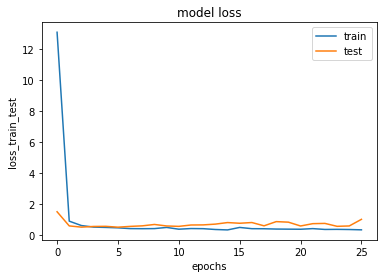

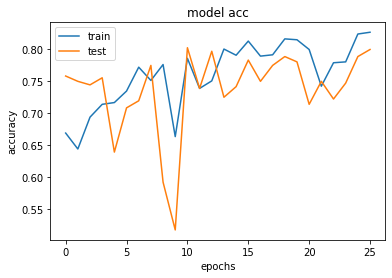

In [53]:
# We now want to plot the train and validation loss functions and accuracy curves
print(history.history.keys())

# summarize history for loss
# START CODE HERE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss_train_test')
plt.xlabel('epochs')
plt.legend(['train', 'test'])
# END CODE HERE
plt.show()

# summarize history for accuracy
# START CODE HERE
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'])
# END CODE HERE
plt.show()


$\large{\underline{\color{blue}{interpretation: }}}$

For this problem, we found a big problem finding the best hyperparameters for the neural network. We tried many architectures with different types of optimizers and a different values for the learning rate, but every time, we overfit the model. ( we obtain 0.01 for the training loss and 0.7 for the validation loss) which is an obvious overfitting. 

Finally, we found this kind of architecutre ,we used 3 layers :
* The first layer with 128 neurones and relu as an activation function .
* The second layer with 64 neurones and relu as an activation function .
* The last layer is with 1 neurone with sigmoid as an activation function.

For the first two layers we also used dropout technique for the regularisation.

We opted for the **Adam** optimizer with a learning rate of **0.005**. We also used early stopping and learning rate decay to avoid overfitting.

We didn't obtain the best results, but at least we are not overfitting the model. Actually, the results are pretty acceptable since we are scoring **85%** accuracy for the train data set / **80%** for the validation and** 79%** for the test data set.

# Conclusion

To conclude, in this binary classification problem, we have tried many algorithms to classify the 2 classes **ants** and **grapes** correctly.  At the end, the **non linear SVM** algorithm gave the best performances overall the metrics that we have choose to evaluate the models on ( 0.93 accuracy ... ). 

Surprisingly, we couldn't repreduce those kind of results with the neural network ( maybe because we couldn't find the best combination of the hyper parameters). Another logical reason behind that, is that we trained the non linear svm on the features extracted from the images and the neural network is trained directly on the pixels of the images ( which have binary values 0/ 255 ). 

We think that for this kind of problem, applying the neural network will not reproduce good results unless we try some techniques like Convolutional Neural Network **CNN** which have the ability to extract features automatically from the images.